# FLEX scRNA pilot
## Merge and plot QC metrics for 5' scRNA samples

- Author: Jacopo Umberto Verga, Kane Foster
- Date: 26/March/2025

After running the doublets detection methods, I am going to:
- Load the samples and merge them in one single anndata file
- Integrate metadata
- Plot QC metrics
- Plot UMAPS to check batch effect

In [3]:
import os
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
def list_files(input_dir):
    samples = os.listdir(input_dir)
    return samples

def create_out_dir(out_dir, sample_name):
    output_dir = out_dir + '/' + sample_name + '/QC/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    return output_dir

def load_sample(file_path):
    adata=sc.read_10x_h5(file_path+'/filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()
    adata.obs['og_barcodes'] =  adata.obs_names
    return adata

def sample_qc_metrics(adata):
    # mitochondrial genes, "MT-" for human, "Mt-" for mouse
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes
    adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
    # ig genes
    adata.var['ig'] = adata.var_names.str.startswith(("IGK","IGH","IGL",))
    # calc
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=["mt", "ribo", "hb","ig"],
        inplace=True,
        log1p=True)
    return adata

def load_update_samples(input_dir, file_path, out_dir):
    adata = load_sample(input_dir+file_path)
    adata = sample_qc_metrics(adata)
    return adata

def load_all_and_merge(input_dir,out_dir):
    files = list_files(input_dir)
    adatas = {}
    for file_path in files:
        adatas[file_path]=load_update_samples(input_dir,file_path,out_dir)
    adata = ad.concat(adatas, label="sample_id")
    adata.obs_names_make_unique()
    # ig pct thr
    adata.obs['thr'] = (adata.obs['pct_counts_ig'] > 1).astype(str)
    return adata

In [14]:
adata = load_all_and_merge('../data/5prime/','../out')
adata

AnnData object with n_obs × n_vars = 235521 × 36601
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_ig', 'log1p_total_counts_ig', 'pct_counts_ig', 'sample_id', 'thr'

## Filter correct samples

In [18]:
# BM, 5'
md = pd.read_csv('../data/sample_md.tsv',sep='\t')
md = md[ (md['mod']=='_5prime') & (md['tissue']=='BM') ]

# Remove odd sample
md = md[md.sample_id!='pM10172_1_BM_CD138pos_GEX_5']

In [22]:
adata = adata[adata.obs.sample_id.isin(md.sample_id),]

In [23]:
adata

View of AnnData object with n_obs × n_vars = 205588 × 36601
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_ig', 'log1p_total_counts_ig', 'pct_counts_ig', 'sample_id', 'thr'

In [34]:
meta = adata.obs

## Sub-sample?

In [ ]:
#...

In [24]:
from IPython.display import Markdown

Markdown(f"""

## Cell Numbers:


Average number of cells from each sample:\n
{round(pd.DataFrame(adata.obs['sample_id'].value_counts()).mean(),2).to_list()[0]}


{pd.DataFrame(adata.obs['sample_id'].value_counts()).to_html()}
""")



## Cell Numbers:


Average number of cells from each sample:

12849.25


<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
    </tr>
    <tr>
      <th>sample_id</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>NDM1069_1_BM_CD138pos_GEX_5</th>
      <td>22655</td>
    </tr>
    <tr>
      <th>pM10172_1_BM_CD138neg_GEX_5</th>
      <td>21137</td>
    </tr>
    <tr>
      <th>pM10978_1_BM_CD138neg_GEX_5</th>
      <td>18465</td>
    </tr>
    <tr>
      <th>pM10978_1_BM_CD138pos_GEX_5</th>
      <td>17783</td>
    </tr>
    <tr>
      <th>pM10879_1_BM_CD138pos_GEX_5</th>
      <td>15645</td>
    </tr>
    <tr>
      <th>pM11104_1_BM_CD138pos_GEX_5</th>
      <td>15523</td>
    </tr>
    <tr>
      <th>pM10938_1_BM_CD138neg_GEX_5</th>
      <td>15070</td>
    </tr>
    <tr>
      <th>pM10879_1_BM_CD138neg_GEX_5</th>
      <td>14745</td>
    </tr>
    <tr>
      <th>pM1726_1_BM_CD138neg_GEX_5</th>
      <td>11835</td>
    </tr>
    <tr>
      <th>pM1726_1_BM_CD138pos_GEX_5</th>
      <td>10268</td>
    </tr>
    <tr>
      <th>pM10938_1_BM_CD138pos_GEX_5</th>
      <td>8916</td>
    </tr>
    <tr>
      <th>pM11104_1_BM_CD138neg_GEX_5</th>
      <td>8900</td>
    </tr>
    <tr>
      <th>NDM1069_1_BM_CD138neg_GEX_5</th>
      <td>7807</td>
    </tr>
    <tr>
      <th>pM10278_1_BM_CD138neg_GEX_5</th>
      <td>6991</td>
    </tr>
    <tr>
      <th>pM10278_1_BM_CD138pos_GEX_5</th>
      <td>5298</td>
    </tr>
    <tr>
      <th>pM10278_2_BM_CD138pos_GEX_5</th>
      <td>4550</td>
    </tr>
  </tbody>
</table>


In [25]:
total = len(adata.obs_names)

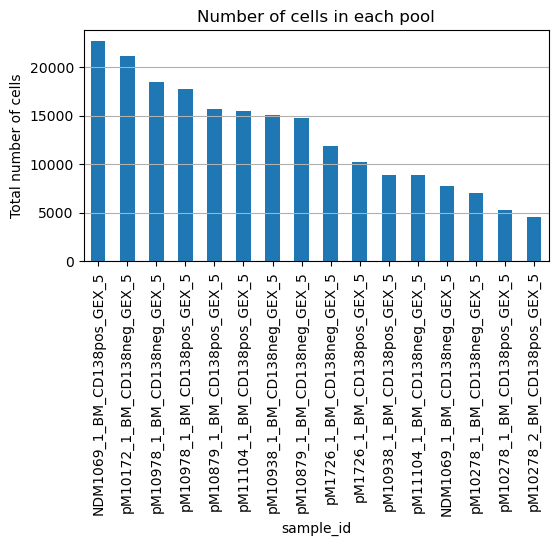

In [26]:
plt.figure(figsize=(6,3))
adata.obs['sample_id'].value_counts().plot.bar()
plt.ylabel('Total number of cells')
plt.grid(axis='y') 
plt.title('Number of cells in each pool')

plt.show()

In [28]:
Markdown(f"""
## QC Plots and metrics

{meta[["n_genes_by_counts", "total_counts", "pct_counts_mt"]].describe().round(1).to_html()}
""")


## QC Plots and metrics

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>n_genes_by_counts</th>
      <th>total_counts</th>
      <th>pct_counts_mt</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>count</th>
      <td>205588.0</td>
      <td>205588.0</td>
      <td>205588.0</td>
    </tr>
    <tr>
      <th>mean</th>
      <td>1601.1</td>
      <td>6324.2</td>
      <td>6.4</td>
    </tr>
    <tr>
      <th>std</th>
      <td>997.0</td>
      <td>7172.0</td>
      <td>10.0</td>
    </tr>
    <tr>
      <th>min</th>
      <td>22.0</td>
      <td>500.0</td>
      <td>0.0</td>
    </tr>
    <tr>
      <th>25%</th>
      <td>934.0</td>
      <td>1996.0</td>
      <td>2.1</td>
    </tr>
    <tr>
      <th>50%</th>
      <td>1484.0</td>
      <td>4156.0</td>
      <td>3.5</td>
    </tr>
    <tr>
      <th>75%</th>
      <td>1993.0</td>
      <td>7656.0</td>
      <td>6.0</td>
    </tr>
    <tr>
      <th>max</th>
      <td>9546.0</td>
      <td>116377.0</td>
      <td>99.7</td>
    </tr>
  </tbody>
</table>


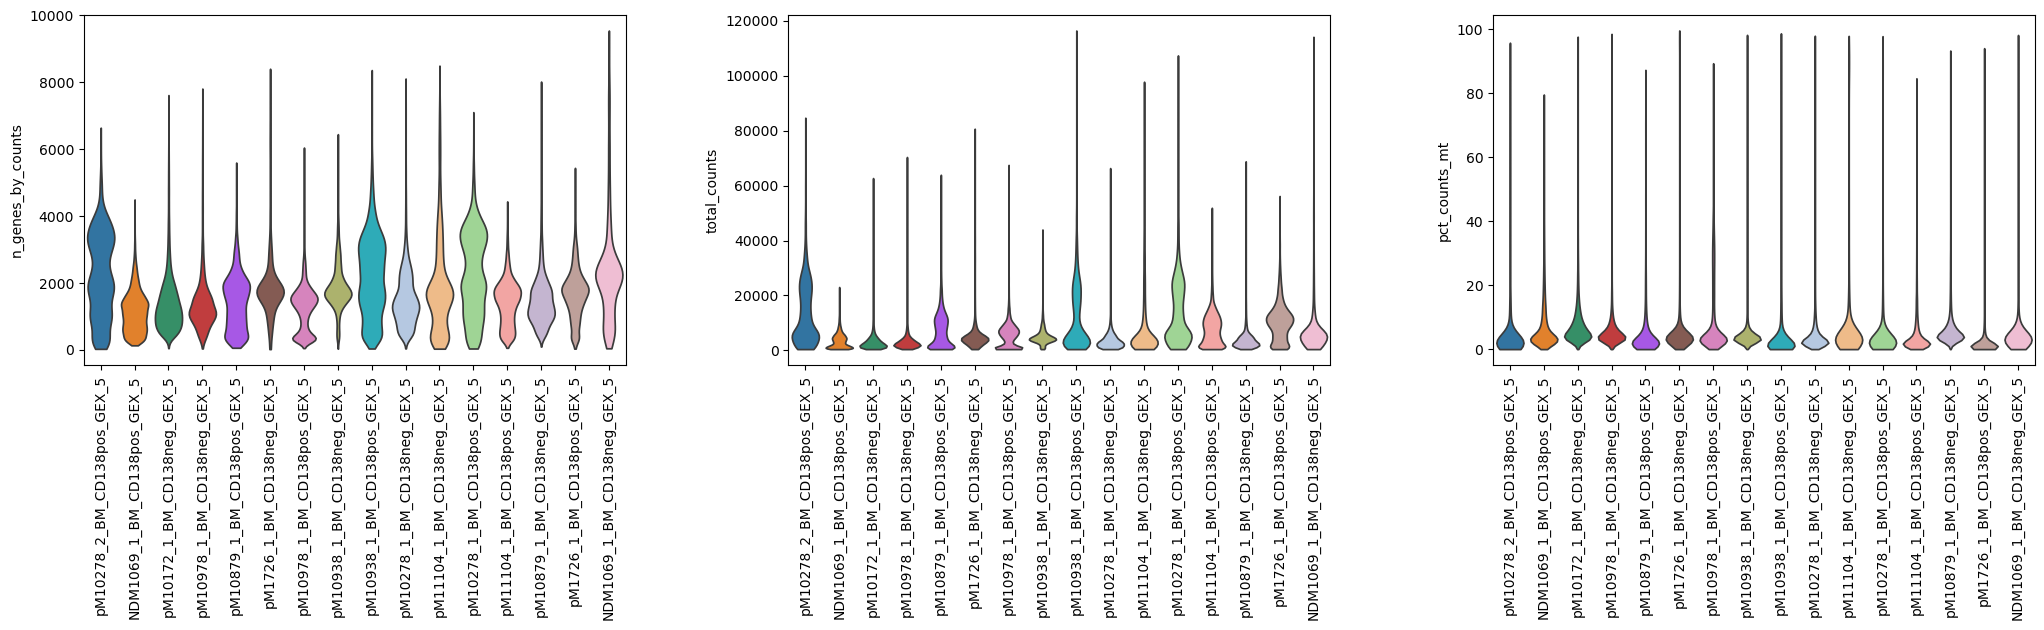

In [29]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    'sample_id',
    multi_panel=False,stripplot=False,rotation=90
)

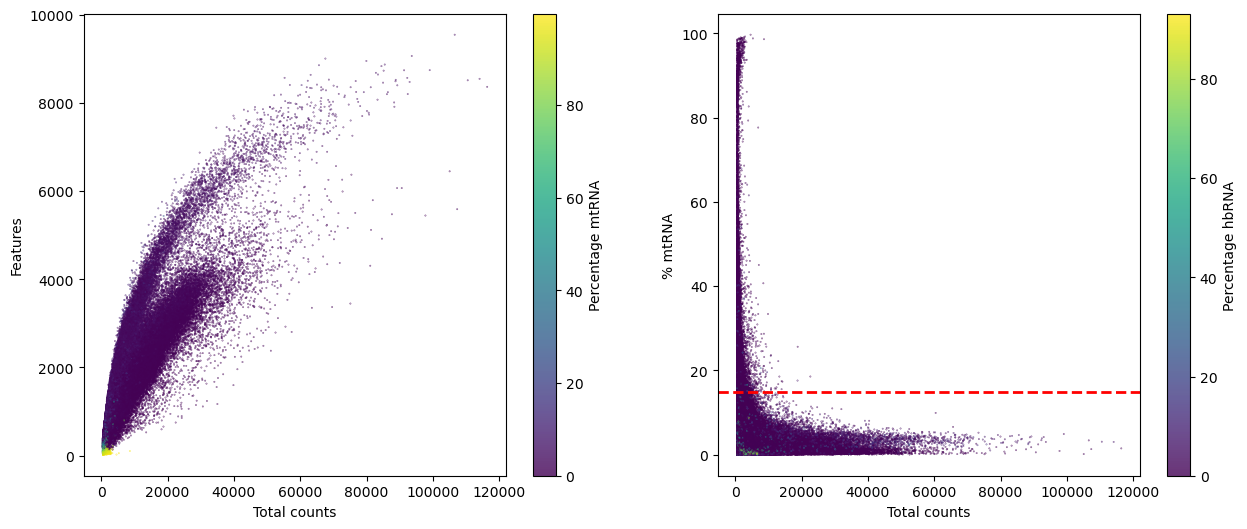

In [30]:
meta
fig, axes = plt.subplots(1,2,figsize=(15,6))
# sns.scatterplot(x=meta['total_counts'],y=meta['n_genes_by_counts'], hue=meta['pct_counts_mt'], ax=axes[0])
# sns.scatterplot(x=meta['total_counts'],y=meta['pct_counts_mt'], hue=meta['pct_counts_hb'], ax=axes[1])


# Create scatter plot
scatter = axes[0].scatter(x=meta['total_counts'],y=meta['n_genes_by_counts'], c=meta['pct_counts_mt'], alpha=0.8,s=.1)
# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Percentage mtRNA')
axes[0].set_ylabel('Features')
axes[0].set_xlabel('Total counts')


scatter_mt = axes[1].scatter(x=meta['total_counts'],y=meta['pct_counts_mt'], c=meta['pct_counts_hb'], alpha=0.8,s=.1)
axes[1].axhline(15, color='red', linestyle='--', linewidth=2)
cbar = plt.colorbar(scatter_mt, ax=axes[1])
cbar.set_label('Percentage hbRNA')
axes[1].set_ylabel('% mtRNA')
axes[1].set_xlabel('Total counts')


plt.show()

In [35]:
mtRNA=10
retrieved = adata[adata.obs['pct_counts_mt'] < mtRNA].shape[0]
proportion_retrieved= (retrieved/adata.shape[0])*100
Markdown(f"""
### mtRNA

Setting the threshold for mtRNA equal to {mtRNA}%, the total number of save retrieved cells is: {retrieved}, {round(proportion_retrieved,2)}% of the total

""")


### mtRNA

Setting the threshold for mtRNA equal to 10%, the total number of save retrieved cells is: 176874, 86.03% of the total



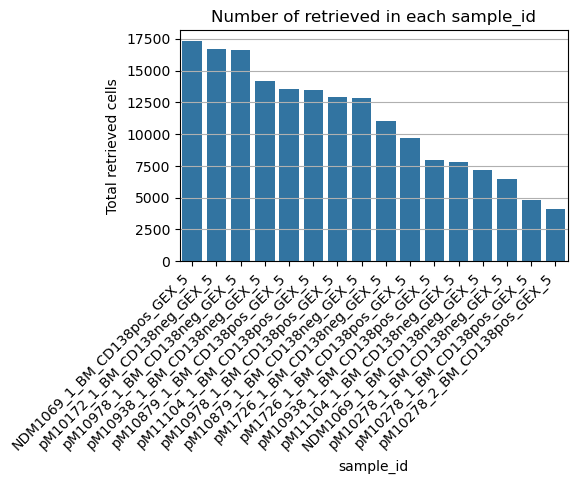

In [36]:
meta['retrieve_mt'] = meta['pct_counts_mt'] < 10
df=meta.groupby('sample_id').agg({
    'retrieve_mt': 'sum'
})
df['retrieve_prop'] = df['retrieve_mt']/ meta['sample_id'].value_counts()
df = df.reset_index()

plt.figure(figsize=(5,3))
sns.barplot(data=df,x='sample_id',y='retrieve_mt',order=df.sort_values('retrieve_mt', ascending=False).sample_id)
plt.ylabel('Total retrieved cells')
plt.grid(axis='y') 
plt.title('Number of retrieved in each sample_id')
plt.xticks(rotation=45, ha='right')
plt.show()

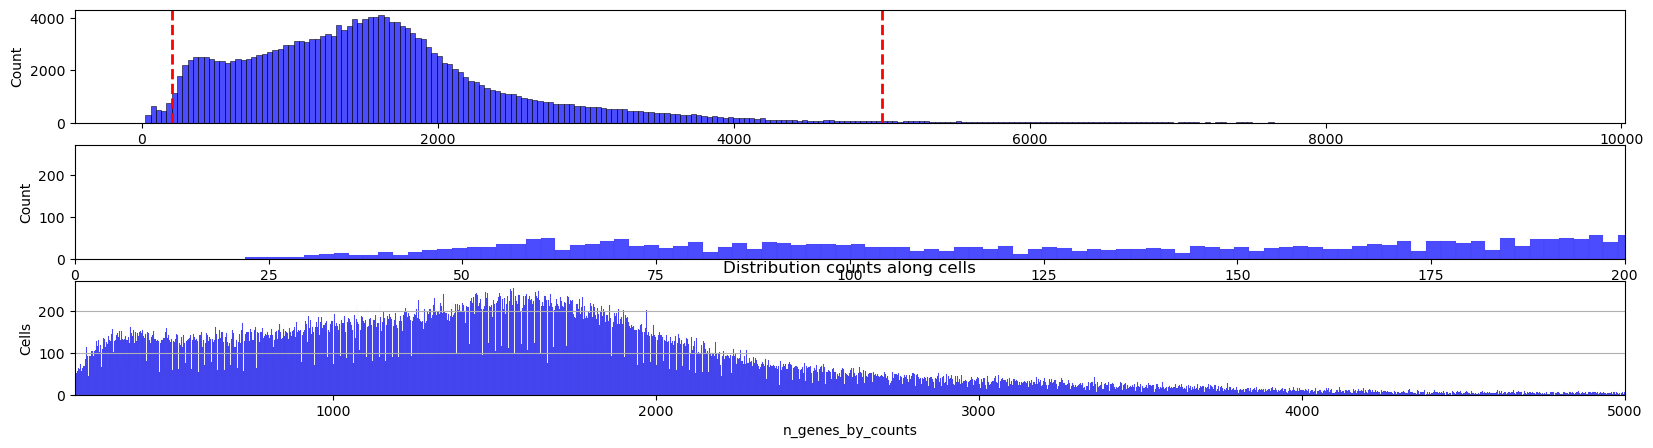

In [38]:
fig, axes = plt.subplots(3,1,figsize=(20, 5))
sns.histplot(meta['n_genes_by_counts'], kde=False, alpha=.7, color='blue', edgecolor='black',ax=axes[0])
sns.histplot(meta['n_genes_by_counts'],bins=5000, kde=False, alpha=.7, color='blue', edgecolor='black',ax=axes[1])
axes[1].set_xlim([0,200])
sns.histplot(meta['n_genes_by_counts'],bins=5000, kde=False, alpha=.7, color='blue', edgecolor='black',ax=axes[2])
axes[2].set_xlim([200,5000])
axes[0].axvline(200, color='red', linestyle='--', linewidth=2)
axes[0].axvline(5000, color='red', linestyle='--', linewidth=2)

plt.ylabel('Cells')
plt.grid(axis='y') 
plt.title('Distribution counts along cells')

plt.show()

# Apply basic filters:


filtering cells by basic thresholds:
- 10% mtRNA
- min 200 genes
- max 5000 genes

In [39]:
max_rna=10
min_genes=200
max_genes=4000

In [40]:
adata_clean = adata[(adata.obs['pct_counts_mt']<max_rna)&(adata.obs['n_genes_by_counts']>min_genes)&(adata.obs['n_genes_by_counts']<max_genes)]
meta_clean = adata_clean.obs
adata_clean

View of AnnData object with n_obs × n_vars = 171056 × 36601
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_ig', 'log1p_total_counts_ig', 'pct_counts_ig', 'sample_id', 'thr', 'retrieve_mt'
    uns: 'sample_id_colors'

In [41]:
Markdown(f"""
- Number of cell retrieved after apply basic filters: {adata_clean.shape[0]}
- Proportion of retrieved cells: {round(adata_clean.shape[0]/adata.shape[0],2)}
- Average number of cells per sample: {round(meta_clean['sample_id'].value_counts().mean(),2)}
- Median number of cells per sample: {meta_clean['sample_id'].value_counts().median()}
""")


- Number of cell retrieved after apply basic filters: 171056
- Proportion of retrieved cells: 0.83
- Average number of cells per sample: 10691.0
- Median number of cells per sample: 11462.0


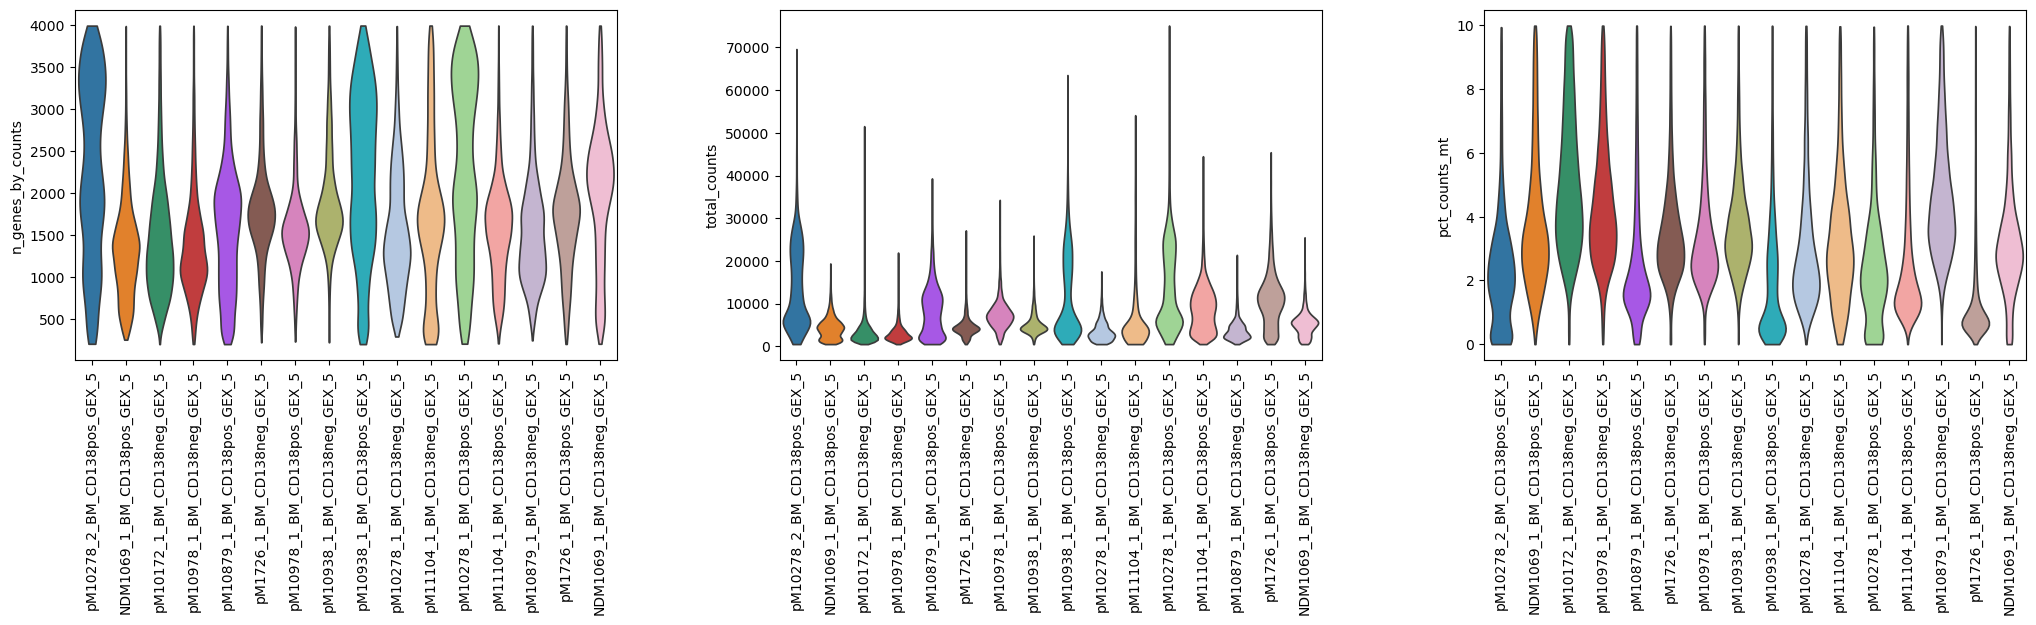

In [42]:
sc.pl.violin(
    adata_clean,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    'sample_id',
    multi_panel=False,stripplot=False,rotation=90
)

Remove samples with low N cells

# Dim reduction and plot

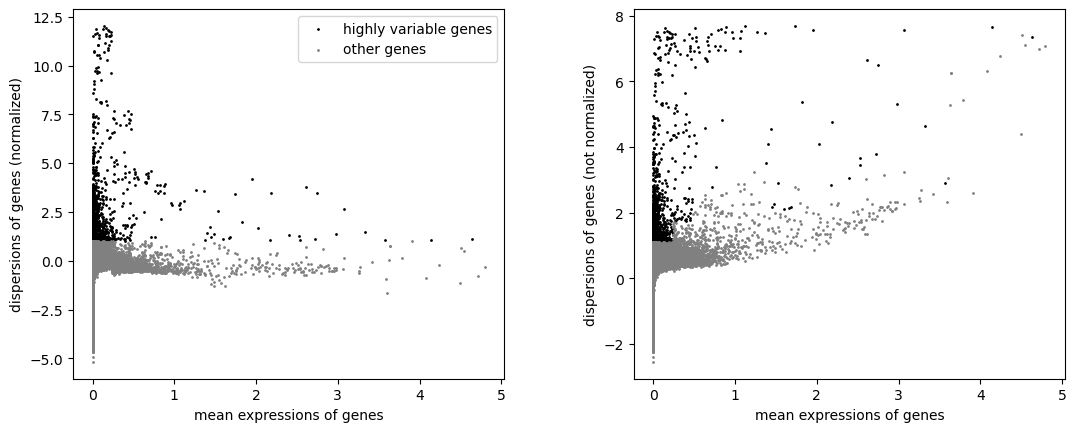

In [43]:
# Saving count data
adata_clean.layers["counts"] = adata_clean.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata_clean)
# Logarithmize the data
sc.pp.log1p(adata_clean)
sc.pp.highly_variable_genes(adata_clean, n_top_genes=2000)
sc.pl.highly_variable_genes(adata_clean)

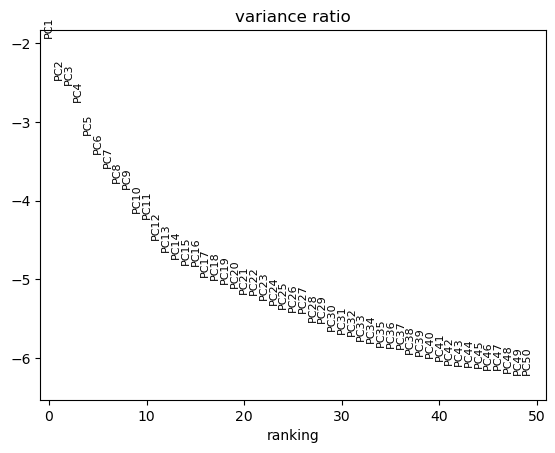

In [44]:
sc.tl.pca(adata_clean,use_highly_variable=True,random_state=12345)
sc.pl.pca_variance_ratio(adata_clean, n_pcs=50, log=True)

In [45]:
# Batch correct PCs with Harmony
import harmonypy as hm
ho = hm.run_harmony(adata_clean.obsm['X_pca'], adata_clean.obs, ['sample_id'])

2025-03-28 18:55:48,035 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-03-28 18:57:54,894 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-03-28 18:57:57,543 - harmonypy - INFO - Iteration 1 of 10
2025-03-28 18:59:47,208 - harmonypy - INFO - Iteration 2 of 10
2025-03-28 19:01:40,740 - harmonypy - INFO - Converged after 2 iterations


In [46]:
adata_clean.obsm['X_pca_harmony'] = np.transpose(ho.Z_corr)

In [47]:
sc.pp.neighbors(adata_clean,n_pcs=50,random_state=12345,use_rep='X_pca_harmony')

In [48]:
sc.tl.umap(adata_clean,random_state=12345)

In [49]:
sc.tl.leiden(adata_clean,resolution=0.5)

In [50]:
adata_clean

AnnData object with n_obs × n_vars = 171056 × 36601
    obs: 'og_barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_ig', 'log1p_total_counts_ig', 'pct_counts_ig', 'sample_id', 'thr', 'retrieve_mt', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sample_id_colors', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

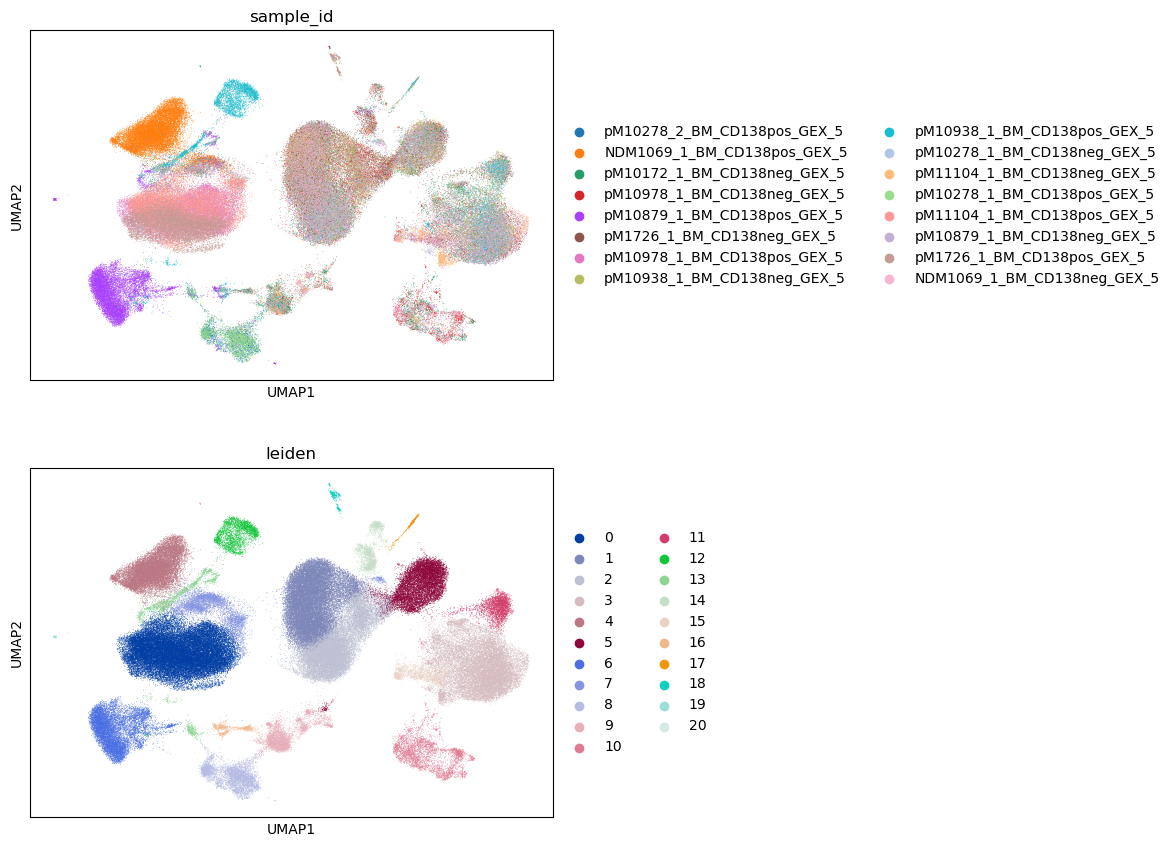

In [51]:
sc.pl.umap(
    adata_clean,
    color=['sample_id','leiden'],
    # Setting a smaller point size to get prevent overlap
    size=1,
    ncols=1
)

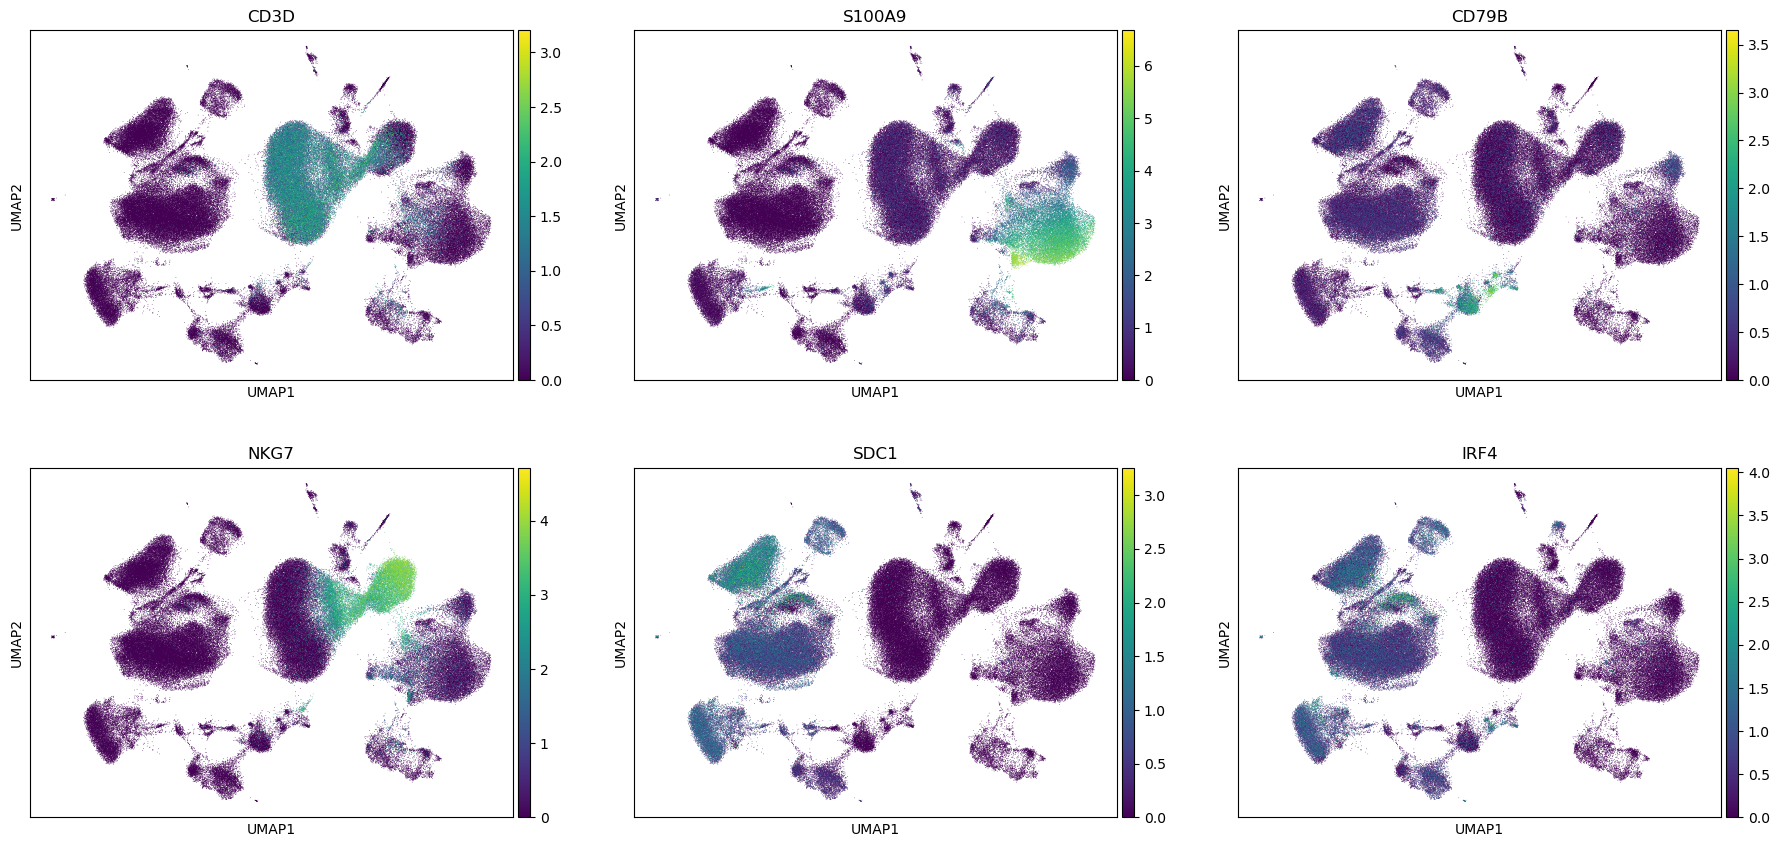

In [52]:
sc.pl.umap(
    adata_clean,
    color=['CD3D','S100A9','CD79B','NKG7','SDC1','IRF4'],
    # Setting a smaller point size to get prevent overlap
    size=1,
    ncols=3
)

In [53]:
adata.write('../out/single_cell_object/adata_5prime_full.h5ad', compression='gzip')
adata_clean.write('../out/single_cell_object/adata_5prime_clean.h5ad', compression='gzip')